# Generative model on MNIST


## Goals

By the end of this tutorial you will:

* Know how to build a discriminative model using cirkit


In this notebook we will loosely follow the RAT SPN paper.
For the paper, the authors had to implement all the circuit operations from scratch in tensorflow.

### Enter Cirkit &#x1F50C; &#x26A1;	
Cirkit's modularity makes building circuits like those used in the RAT SPN paper extremely easy. In addition, it becomes very easy to test variants, as we will do in this notebook.

# Load Image Data  &#x1F5BC;	&#x1F5B4;

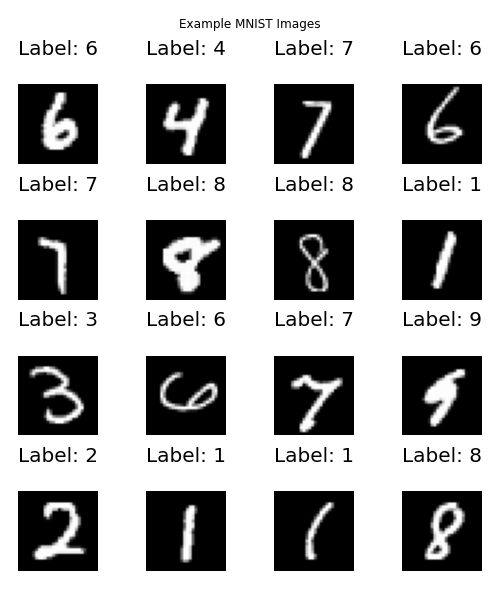

In [157]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

NUM_DIGITS = 10
PIXEL_RANGE=255
# Store an example image
example_image = None

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (PIXEL_RANGE * x).long())
])

# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    images, labels = next(iter(dataloader))
    
    example_image = images[0]
    images = images[:gridsize**2]
    
    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))
    
    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
    # Adjust spacing between subplots
    fig.suptitle('Example MNIST Images')
    plt.tight_layout()
    plt.show()


data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Call the function to plot images
plot_sample_images(train_dataloader, gridsize=4)

# Fit the Circuit &#x1F50C;

We already saw how to fit a circuit to maximise the likelihood of the data.
We now consider building a discriminative classifier.

# Building Generative AI

In what follows:

* $\mathbf{x}$ are the pixels of an image
* $y$ is the MNIST digit class, i.e. $y \in \{1,\ldots,10\}$ 

We have [already seen](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb) how we can use a circuit to model the likelihood of our images, i.e. $P(x)$. But so far we have ignored the class of each image. What about modelling $P(y \mid x)$?

We will start by modelling $P(x \mid y)$. We will create a circuit that outputs $10$ log-probabilities: the probability mass over images for each class.

### Bayes' rule


$$P(y \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid y)P(y)}{\sum_y P(\mathbf{x} \mid y)P(y)}$$



Check your understanding: why did we bother using Bayes' rule? Why did we not just directly use the outputs from the circuit as the probabilities?

In [158]:
from cirkit.symbolic.circuit import Circuit
from cirkit.templates.region_graph import RandomBinaryTree, RegionGraph
from cirkit.symbolic.layers import CategoricalLayer
from cirkit.templates.circuit_templates.utils import Parameterization, parameterization_to_factory
from cirkit.templates.region_graph import QuadTree


NUM_INPUT_UNITS = 64
NUM_SUM_UNITS = 64
PIXEL_RANGE=255


def build_class_conditional_classifier(num_classes: int,
                                       rg: RegionGraph,
                                       sum_prod_layer: str = 'cp') -> Circuit:
    input_factory = lambda scope, y, z: CategoricalLayer(
        scope=scope,
        num_categories=PIXEL_RANGE+1,
        num_channels=1, # These are grayscale images
        num_output_units=NUM_INPUT_UNITS # Overparameterization
    )

    # Note that below intialisation is needed
    sum_weight_param = Parameterization(activation='softmax', initialization='normal')
    sum_weight_factory = parameterization_to_factory(sum_weight_param)
    
    circuit = Circuit.from_region_graph(
        rg,
        input_factory=input_factory,
        sum_weight_factory= sum_weight_factory,
        num_sum_units=NUM_SUM_UNITS,
        sum_product=sum_prod_layer,
        num_classes=num_classes,
    )
    return circuit


qt = QuadTree([28, 28], num_patch_splits=2)
circuit = build_class_conditional_classifier(NUM_DIGITS, qt, 'cp')

In [ ]:
from cirkit.pipeline import compile

    
# Set the torch device to use
device = torch.device('cpu')

model = compile(circuit)
# Move the circuit to chosen device
model = model.to(device)


# Set some seeds
np.random.seed(42)
torch.manual_seed(42)


num_epochs = 5
step_idx = 0
running_loss = 0.0
stats = dict()

# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


prior = torch.ones(NUM_DIGITS)/ NUM_DIGITS   # We use a uniform prior


for epoch_idx in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        BS = images.shape[0]
        
        images = images.view(BS, 1, -1).to(device)
        labels = labels.view(BS).to(device)
        
        # Compute the log-likelihoods of the batch, by evaluating the circuit
        cond_log_likelihoods = model(images).view(BS, -1)
        
        # At this point, we can either marginalise and ignore the y info
        # or we can maximise the likelihood of the image under the label
        cond_lls = cond_log_likelihoods[np.arange(BS), labels]
        log_priors = np.log(prior[labels])
        
        # We take the negated average log-likelihood as loss
        loss = -torch.mean(cond_lls + log_priors)
        
        
        loss.backward()
        
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * BS
        step_idx += 1
        if step_idx % 10 == 0:
            average_nll = running_loss / (10 * BS)
            print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
            running_loss = 0.0

            # stats['train loss'].append(average_nll.cpu().item())

Step 10: Average NLL: 726.725


In [172]:
with torch.no_grad():
    test_lls = 0.0

    for images, labels in test_dataloader:
        BS = images.shape[0]
        
        images = images.view(BS, 1, -1).to(device)
        labels = labels.view(BS).to(device)

        # Compute the log-likelihoods of the batch, by evaluating the circuit
        cond_log_likelihoods = model(images).view(BS, -1)

        
        # At this point, we can either marginalise and ignore the y info
        # or we can maximise the likelihood of the image under the label
        cond_lls = cond_log_likelihoods[np.arange(BS), labels]
        log_priors = np.log(prior[labels])
        
        # Compute log-likelihoods
        log_likelihoods = cond_lls + log_priors

        # Accumulate the log-likelihoods
        test_lls += log_likelihoods.sum().item()

    # Compute average test log-likelihood and bits per dimension
    average_nll = - test_lls / len(data_test)
    bpd = average_nll / (28 * 28 * np.log(2.0))
    print(f"Average test LL: {average_nll:.3f}")
    print(f"Bits per dimension: {bpd:.3f}")

    stats['test loss'] = average_nll
    stats['test bits per dimension'] = bpd

Average test LL: 731.909
Bits per dimension: 1.347


# Taking it a step further

In [129]:
# quad-graph
# (mu)SOCS and PICS